Import pandas, numpy, matplotlib and sklearn

In [1]:
#import libraries

import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  
from sklearn.feature_selection import SelectFromModel, RFECV

In [2]:
#load train data
df_train = pd.read_csv('Data/train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
#load test data
df_test = pd.read_csv('Data/test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


## Regression

In [4]:
#Prepare data for regression model

# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_adxf = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

# features with low or no correlation with regression label
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

# a variable to hold the set of features to experiment with
features = features_orig


X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

In [5]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [6]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """Plot regression coefficients weights or feature importance.
    
    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'
        
    Returns:
        plot of either regression coefficients weights or feature importance
        
    
    """
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

In [7]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    
    """Print the regression residuals.
    
    Args:
        model (str): The model name identifier
        y_train (series): The training labels
        y_train_pred (series): Predictions on training data
        y_test (series): The test labels
        y_test_pred (series): Predictions on test data
        
    Returns:
        Plot of regression residuals
    
    """
    
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

## Linear Regression

In [8]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.580, R^2 test: 0.405


,Linear Regression
Root Mean Squared Error,32.041095
Mean Absolute Error,25.591780
R^2,0.405495
Explained Variance,0.665297


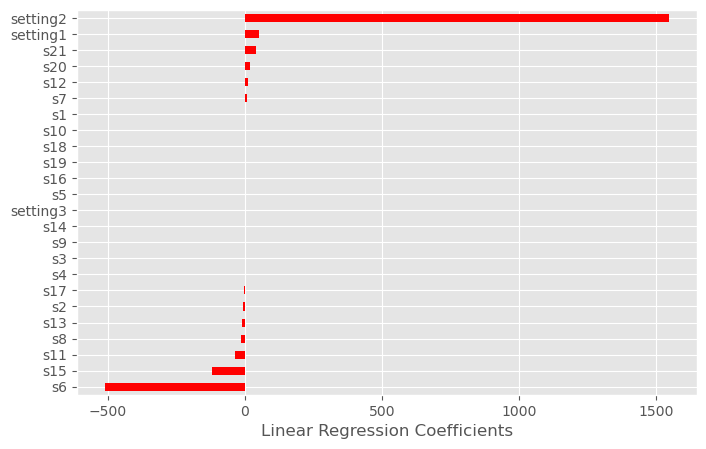

In [9]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')


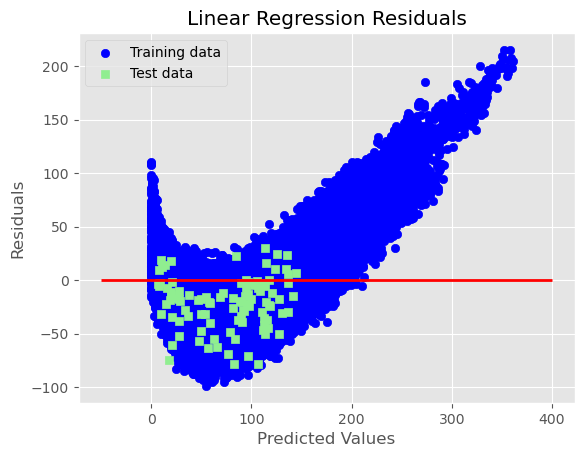

In [10]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

## LASSO

In [11]:
lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('LASSO', y_test, y_test_predict)

lasso_metrics

R^2 training: 0.579, R^2 test: 0.408


,LASSO
Root Mean Squared Error,31.966099
Mean Absolute Error,25.551808
R^2,0.408275
Explained Variance,0.668206


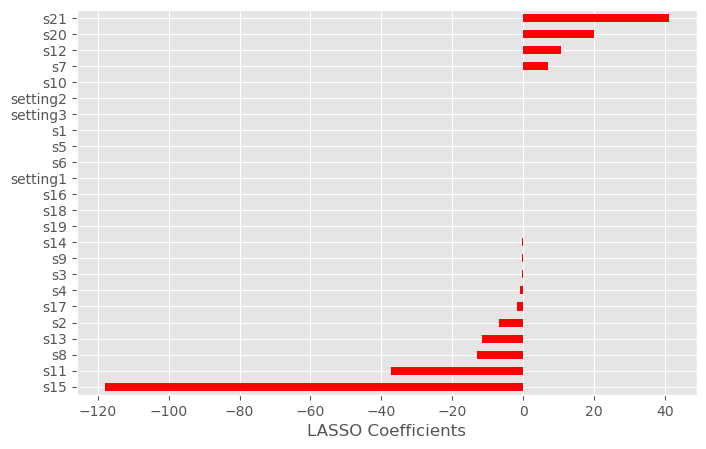

In [12]:
plot_features_weights('LASSO', lasso.coef_, X_train.columns, 'c')

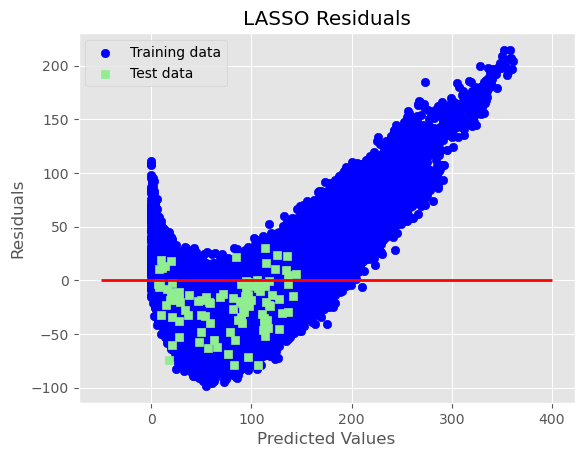

In [13]:
plot_residual('LASSO', y_train_predict, y_train, y_test_predict, y_test)


## Ridge

In [14]:
rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.580, R^2 test: 0.408


,Ridge Regression
Root Mean Squared Error,31.965740
Mean Absolute Error,25.544620
R^2,0.408289
Explained Variance,0.667607


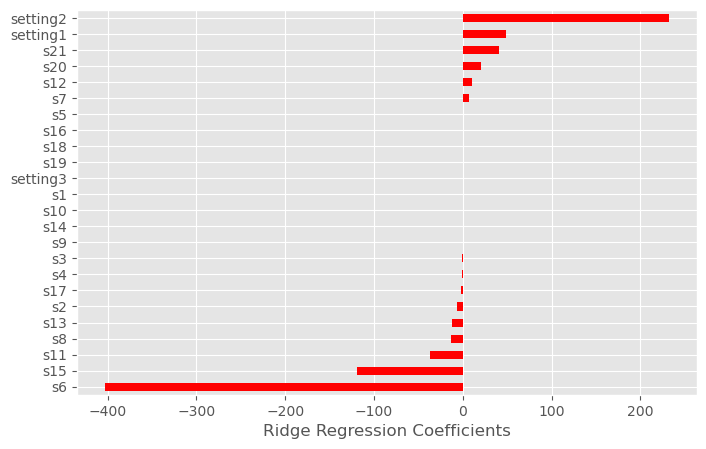

In [15]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

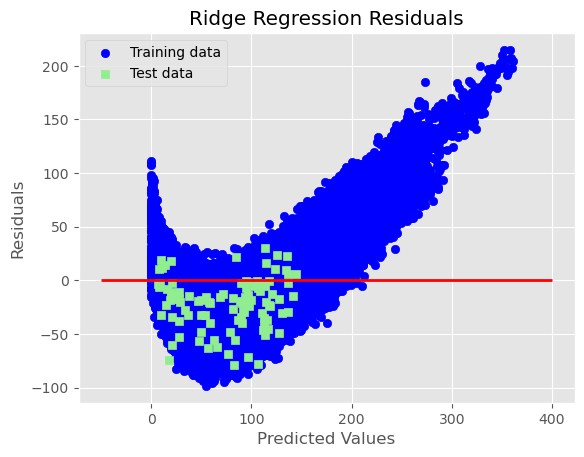

In [16]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)

## Polynomial

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.627, R^2 test: 0.414


,Polynomial Regression
Root Mean Squared Error,31.814768
Mean Absolute Error,24.186406
R^2,0.413865
Explained Variance,0.637227


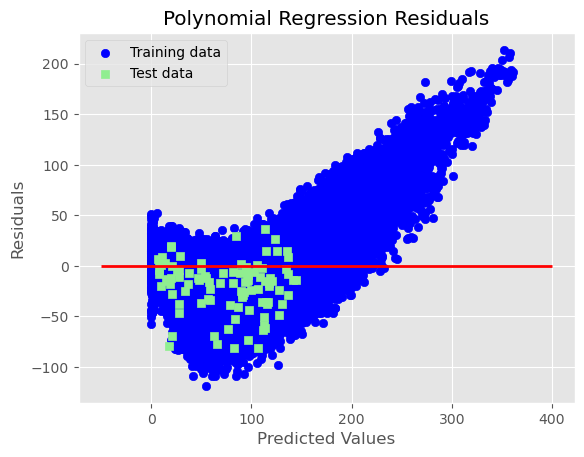

In [18]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

## Compare all regression model tested

In [21]:
reg_metrics_bfe = pd.concat([linreg_metrics, lasso_metrics, rdg_metrics, polyreg_metrics], axis=1)
reg_metrics_bfe

,Linear Regression,LASSO,Ridge Regression,Polynomial Regression
Root Mean Squared Error,32.041095,31.966099,31.965740,31.814768
Mean Absolute Error,25.591780,25.551808,25.544620,24.186406
R^2,0.405495,0.408275,0.408289,0.413865
Explained Variance,0.665297,0.668206,0.667607,0.637227
